In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from DMS2_multiday_plots_utils import *
from DMS2_fetch_protocol_data import *
# settings
%load_ext autoreload
%autoreload 2

sns.set_context("talk")

[2023-05-17 14:38:32,662][INFO]: Connecting jbreda@bdata00.pni.princeton.edu:3306
[2023-05-17 14:38:33,310][INFO]: Connected jbreda@bdata00.pni.princeton.edu:3306


In [50]:
def create_figure(figsize=(10, 3)):
    fig, ax = plt.subplots(figsize=figsize)
    return fig, ax

In [22]:
date_min, date_max = return_date_window(latest_date=None, n_days_back=20)

In [24]:
df = fetch_latest_training_data(
    animal_ids=None, 
    date_min=date_min, 
    date_max=date_max
)
r610 = df.query("animal_id == 'R610'")

fetched 19 sessions for R610 between 2023-04-27 and 2023-05-17
fetched 19 sessions for R611 between 2023-04-27 and 2023-05-17
fetched 19 sessions for R612 between 2023-04-27 and 2023-05-17
fetched 19 sessions for R613 between 2023-04-27 and 2023-05-17
fetched 19 sessions for R614 between 2023-04-27 and 2023-05-17


In [12]:
# df.to_csv('df.csv', index=False) # already ran this
df = pd.read_csv('df.csv') # run if needed
r610 = df.query("animal_id == 'R610'")

## Trials Plot

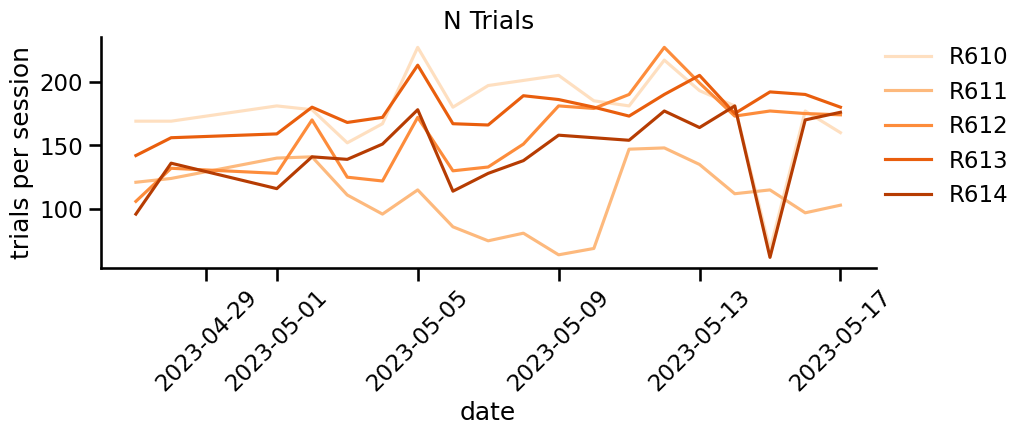

In [52]:
fig,ax = create_figure()
plot_multianimal_trials(df, ax)


In [66]:
df.groupby(["date"]).max().trial / np.arange(1,20)

date
2023-04-27    169.000000
2023-04-28     84.500000
2023-05-01     60.333333
2023-05-02     45.000000
2023-05-03     33.600000
2023-05-04     28.666667
2023-05-05     32.428571
2023-05-06     22.500000
2023-05-07     21.888889
2023-05-08     20.100000
2023-05-09     18.636364
2023-05-10     15.416667
2023-05-11     14.615385
2023-05-12     16.214286
2023-05-13     13.666667
2023-05-14     11.312500
2023-05-15     11.294118
2023-05-16     10.555556
2023-05-17      9.473684
Name: trial, dtype: float64

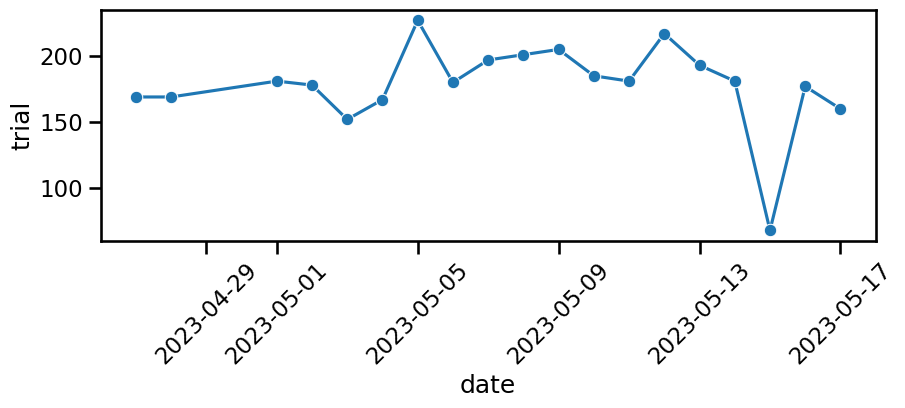

In [72]:
fig,ax = create_figure()


sns.lineplot(
    r610.groupby(["date"]).max().trial,
    marker="o",
    ax=ax,
)

ax.tick_params(axis="x", labelrotation=45)


In [78]:
def calculate_daily_trial_rate(animal_id, date, units="hours"):
    """
    function that queries the sessions dj table to determine
    what the trial rate (in hours or minutes) was for an animal
    for a given day. Drops sessions with 1 or less trials from calc.

    params
    ------
    animal_id : str
        animal name, e.g. "R500"
    date : str or datetime
        date of interest in YYYY-MM-DD, e.g. "2023-04-12"
    units : str, "hours" (default) or "minutes"
        what units to return trial rate in
    """
    # fetch data
    query_keys = {
        "ratname": animal_id,
        "sessiondate": date,
    }  # specific to Sessions table
    n_done_trials, start_times, end_times = (bdata.Sessions & query_keys).fetch(
        "n_done_trials", "starttime", "endtime"
    )

    # convert to rate
    time_conversion = 1 / 3600 if units == "hours" else 1 / 60
    daily_train_time_seconds = (
        end_times[n_done_trials > 1] - start_times[n_done_trials > 1]
    )[0].seconds
    daily_trial_rate = np.sum(n_done_trials[n_done_trials > 1]) / (
        daily_train_time_seconds * time_conversion
    )

    return np.round(daily_trial_rate, decimals=2)

In [94]:
len(end_times)

19

In [110]:
bdata.Sessions.describe

<bound method Table.describe of *sessid    ratname     hostname       experimenter   starttime     endtime      sessiondate    n_done_trials  comments     settings_file  settings_path  data_file      data_path      video_file     video_path     protocol     total_correct  right_correct  left_correct   percent_violat brokenbits     protocol_d left_pokes     center_pokes   right_pokes    technotes     IP_addr     crashed     foodpuck    
+--------+ +---------+ +------------+ +------------+ +-----------+ +----------+ +------------+ +------------+ +----------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +----------+ +------------+ +------------+ +------------+ +------------+ +------------+ +--------+ +------------+ +------------+ +------------+ +-----------+ +---------+ +---------+ +----------+
0          J064        Rig25          Jeff           13:07:47      15:11:25     2010-09-20     243                                                      

In [126]:
unique_dates = r610.date.unique().tolist()
# date_strings = [date.strftime('%Y-%m-%d') for date in unique_dates]
# date_strings
units = "hours"
keys = [{'ratname': "R610",'sessiondate' : date} for date in unique_dates]
n_done_trials, start_times, end_times, dates = (bdata.Sessions & keys).fetch(
    "n_done_trials", "starttime", "endtime", "sessiondate"
)


filter = n_done_trials > 1
n_done_trials, start_times, end_times, dates = (n_done_trials[filter], 
                                                start_times[filter], 
                                                end_times[filter], 
                                                dates[filter])

time_conversion = 1 / 3600 if units == "hours" else 1 / 60
session_train_time_seconds = end_times - start_times
converted_time_dur = np.array([td.total_seconds() / 3600 for td in session_train_time_seconds])
session_trial_rate = n_done_trials / converted_time_dur

# session_trial_rate = n_done_trials /  

# for isess in range(len(end_times)):
    
#     daily_train_time_seconds = (end_times[isess] - start_times[isess]
#     )[0].seconds
# #     daily_trial_rate = np.sum(n_done_trials[n_done_trials > 1]) / (
# #         daily_train_time_seconds * time_conversion
# # )

In [ ]:
if np.any(duplicate_mask):
    # Filter the duplicate dates and corresponding rates
    duplicated_dates = unique_dates[duplicate_mask]
    duplicated_rates = session_trial_rate[duplicate_mask]
    # duplicated_rates = session_trial_rate[duplicate_indices][duplicate_mask]

    # Create a dictionary to store the cumulative rates and count for each date
    averaged_dict = {}

    # Iterate over the duplicated dates and rates, and accumulate the rates for each date
    for date, rate in zip(duplicated_dates, duplicated_rates):
        if date in averaged_dict:
            averaged_dict[date][0] += rate
            averaged_dict[date][1] += 1
        else:
            averaged_dict[date] = [rate, 1]

    # Calculate the average rate for each date
    averaged_dates = np.array(list(averaged_dict.keys()))
    averaged_rates = np.array([averaged_dict[date][0] / averaged_dict[date][1] for date in averaged_dates])

    print(averaged_dates)
    print(averaged_rates)
else:
    print("No duplicate dates found.")

In [106]:
end_times[isess] - start_times[isess]

datetime.timedelta(seconds=3711)

In [80]:
calculate_daily_trial_rate("R610", "2023-05-17")

155.21

In [49]:
# TODO single animal trial plot
# TODO trial rate plot 

## Stage plots

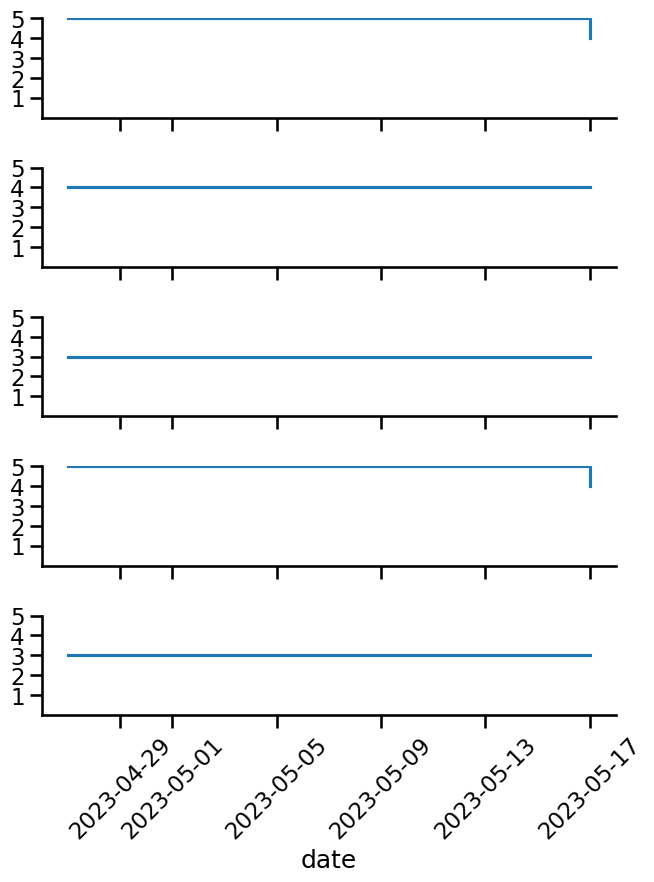

In [26]:
fig,ax=plt.subplots(5,1, figsize=(7,8), sharey=True, sharex=True)
plt.tight_layout()
for ii, (animal_id,sub_df) in enumerate(df.groupby(["animal_id"])):
    plot_stage(sub_df, ax[ii])
    ax[ii].set(ylim=(0,5), ylabel="")
    

In [8]:
"""Not working"""
def plot_trials_in_stage(df, ax, title=None):
    sub_df.groupby("stage").sum().trial.plot(kind="bar",ax=ax)


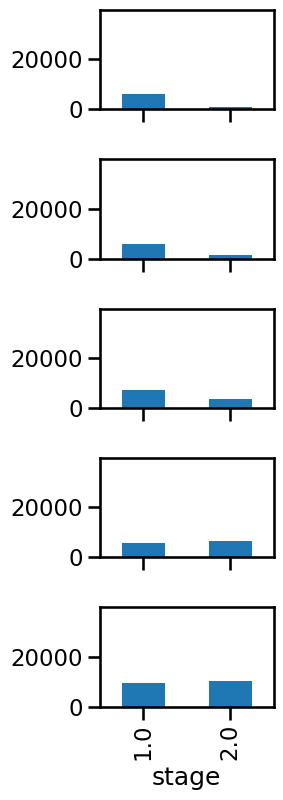

In [9]:
fig,ax=plt.subplots(5,1, figsize=(3,8), sharey=True, sharex=True)
plt.tight_layout()
for ii, (animal_id,sub_df) in enumerate(df.groupby(["animal_id"])):
    plot_trials_in_stage(sub_df, ax[ii], title=animal_id)
    ax[ii].set(ylabel="")
    None

## Bias Plots

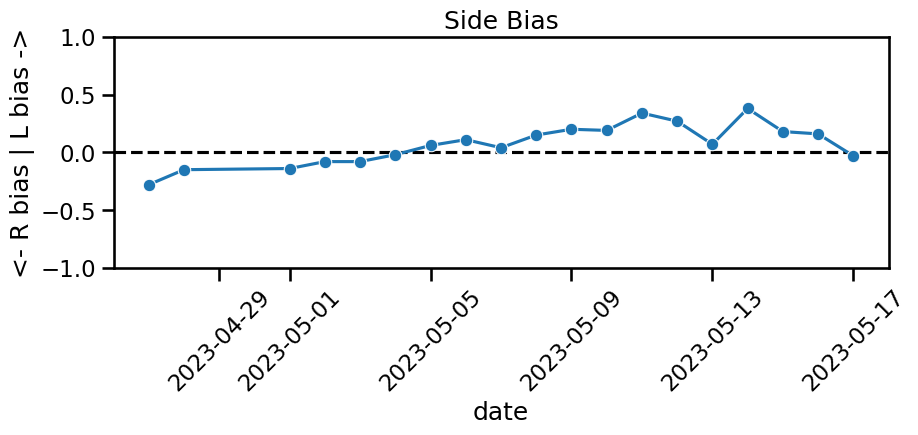

In [53]:
fig,ax = create_figure()
plot_multiday_side_bias(r610, ax)


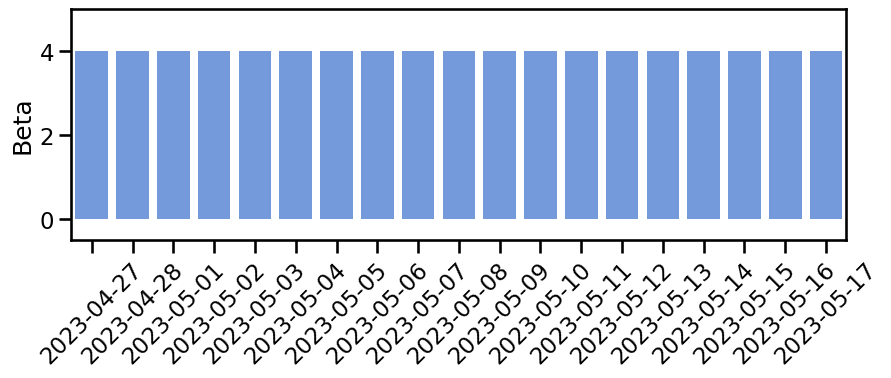

In [54]:
fig,ax = create_figure()

plot_multiday_antibias_beta(r610, ax)

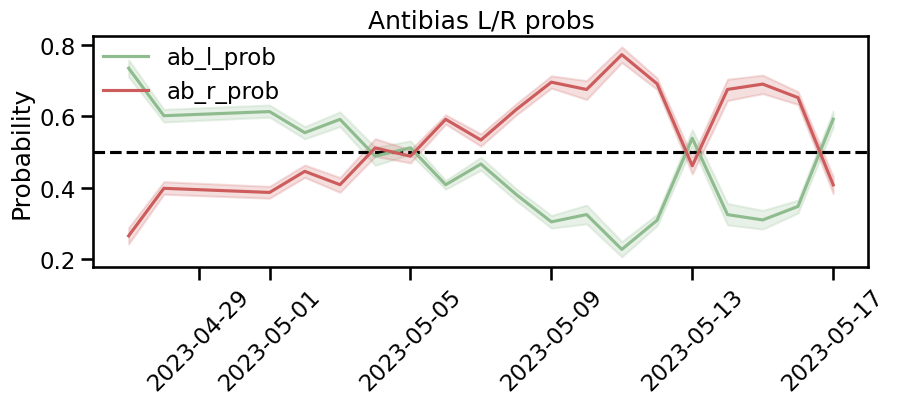

In [30]:
fig,ax = plt.subplots(figsize=(10,3))

plot_multiday_antibias_probs(r610, ax)


## Water plot

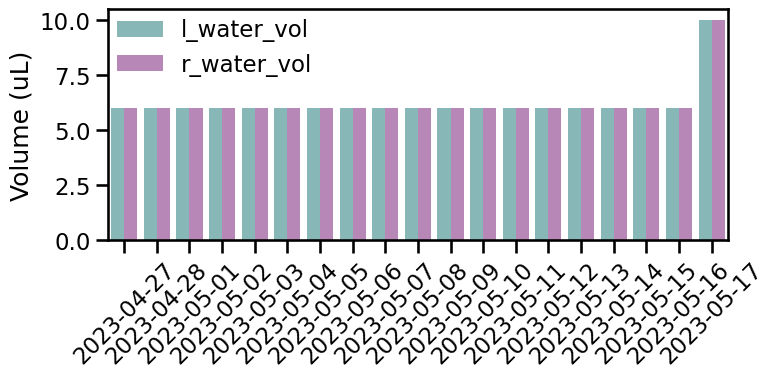

In [31]:
fig,ax = plt.subplots(figsize=(8,3))

plot_multiday_water_vols(r610, ax)


### TODO
* water plot with pub water
* mass plot (kinda related^)

## Trial result plot

In [32]:
x = r610.groupby(["date"]).result.value_counts(normalize="True").reset_index(["date"])


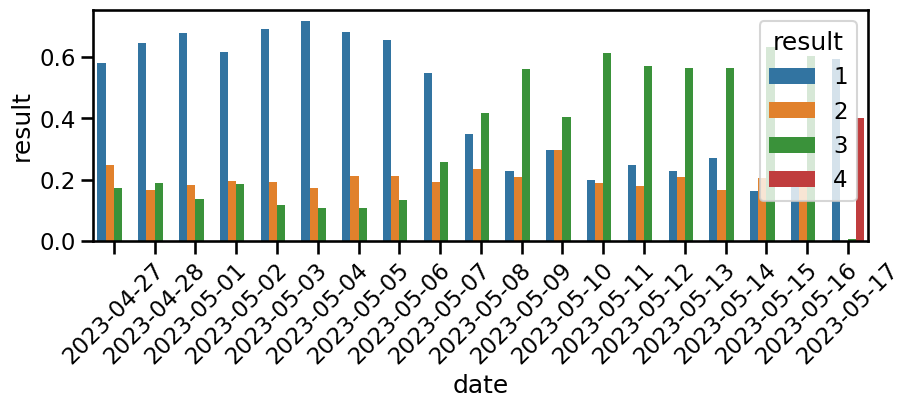

In [33]:
fig,ax= plt.subplots(figsize=(10,3))
sns.barplot(data=x, x="date", y="result", hue=x.index,ax=ax)
ax.tick_params(axis="x", labelrotation=45)


In [36]:
y = r610.groupby(["date"]).result.value_counts(normalize=True).unstack()


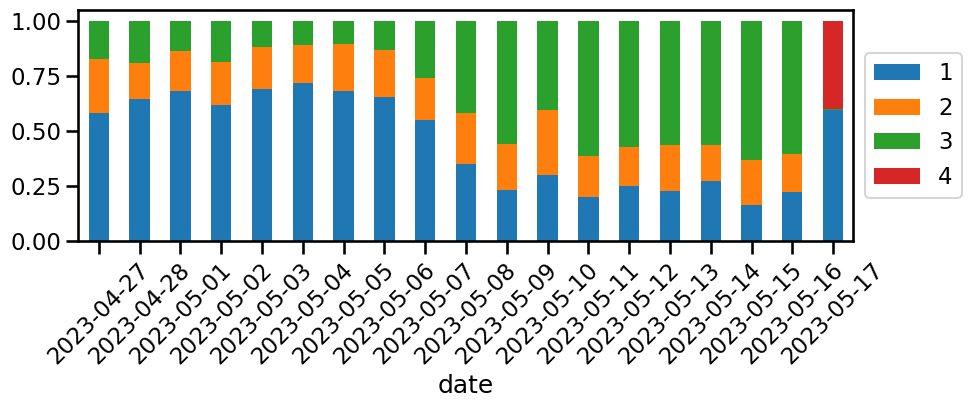

In [41]:
# Create the stacked bar chart
fig, ax = plt.subplots(figsize=(10, 3))
y.plot(kind='bar', stacked=True, ax=ax)

# Rotate x-axis labels
ax.tick_params(axis="x", labelrotation=45)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.show()

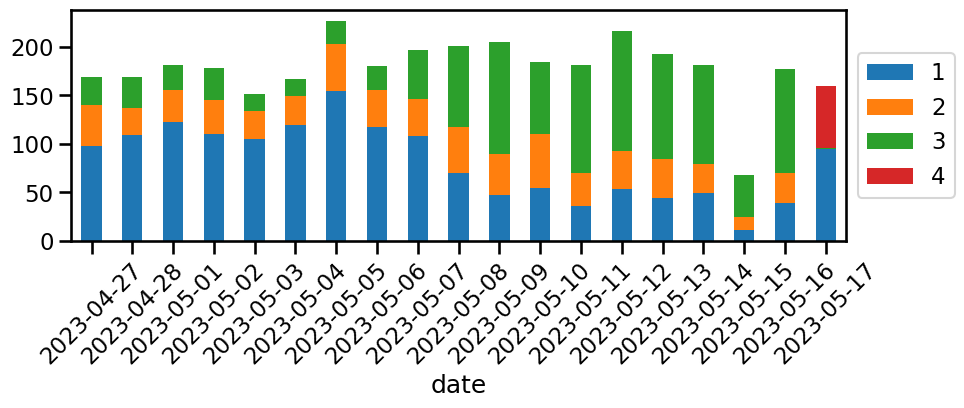

In [40]:
z = r610.groupby(["date"]).result.value_counts().unstack()
fig, ax = plt.subplots(figsize=(10, 3))
z.plot(kind='bar', stacked=True, ax=ax)

# Rotate x-axis labels
ax.tick_params(axis="x", labelrotation=45)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.show()

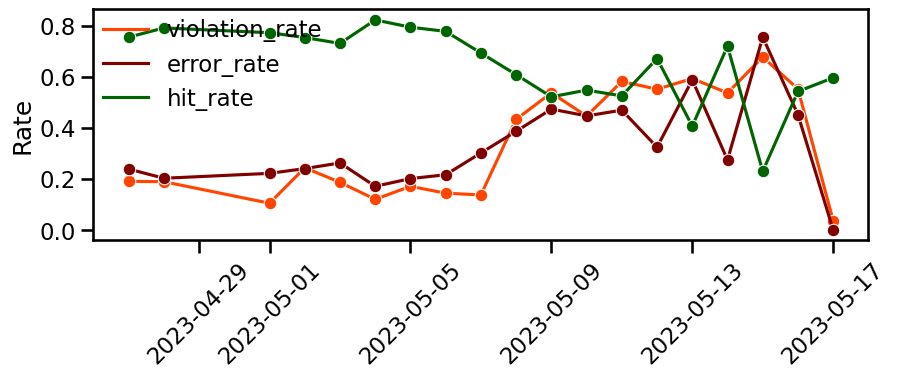

In [35]:
fig,ax = plt.subplots(figsize =(10,3))

plot_multiday_perfs(r610, ax)


## Timing Params

-pre_go, viol_dur, delay_dur (all on one plot?)
- cumulative delay_dur, colored by was_violation or was_noanswers